In [1]:
import sys
sys.path.append('..')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".20"
import numpy as np
import h5py
import matplotlib.pyplot as plt
from pathlib import Path
import flowrec.training_and_states as state_utils

In [2]:
results_dir = "../local_results/ff_combined/221117165907"

In [3]:
with h5py.File(Path(results_dir,'results.h5'),'r') as hf:
    # ux_loss_train = np.array(hf.get("ux_loss_train"))
    # ux_loss_val = np.array(hf.get("ux_loss_val"))
    ux_loss_train = np.array(hf.get("loss_train"))
    ux_loss_val = np.array(hf.get("loss_val"))
    ux_train = np.array(hf.get("ux_train"))
    ux_val = np.array(hf.get("ux_val"))
    ux_test = np.array(hf.get("ux_test"))
    
    # uy_loss_train = np.array(hf.get("uy_loss_train"))
    # uy_loss_val = np.array(hf.get("uy_loss_val"))
    uy_train = np.array(hf.get("uy_train"))
    uy_val = np.array(hf.get("uy_val"))
    uy_test = np.array(hf.get("uy_test"))
    
    pb_train = np.array(hf.get("pb_train"))
    pb_val = np.array(hf.get("pb_val"))
    pb_test = np.array(hf.get("pb_test"))

    ux_train_m = np.array(hf.get("ux_train_m"))
    ux_val_m = np.array(hf.get("ux_val_m"))
    ux_test_m = np.array(hf.get("ux_test_m"))

    uy_train_m = np.array(hf.get("uy_train_m"))
    uy_val_m = np.array(hf.get("uy_val_m"))
    uy_test_m = np.array(hf.get("uy_test_m"))

    pb_train_m = np.array(hf.get("pb_train_m"))
    pb_val_m = np.array(hf.get("pb_val_m"))
    pb_test_m = np.array(hf.get("pb_test_m"))

(ntrain,nx,ny) = ux_train.shape
nval = ux_val.shape[0]
ntest = ux_test.shape[0]

In [4]:
with h5py.File(Path(results_dir,'parameters.h5'),'r') as hf:
    layers = list(hf.get("layers"))

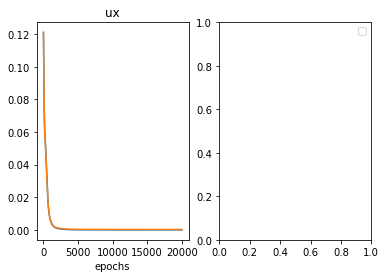

In [5]:
# loss
fig,ax = plt.subplots(1,2)
ax[0].plot(ux_loss_train,label='train')
ax[0].plot(ux_loss_val,label='val')
ax[0].set(title='ux',xlabel='epochs')
# ax[1].plot(uy_loss_train,label='train')
# ax[1].plot(uy_loss_val,label='val')
# ax[1].set(title='uy',xlabel='epochs')
plt.legend()
plt.show()

# Get model

In [15]:
import jax
import jax.numpy as jnp
from flowrec.models.feedforward import Model as FeedForward
from flowrec.losses import loss_mse, mse

In [7]:
mdl = FeedForward(layers,jax.random.PRNGKey(10))
loss = loss_mse

In [8]:
def mae_plane(x,y):
    plane = jnp.einsum('t x y-> x y', jnp.abs(x-y)) / x.shape[0]
    return plane

# Plot results

## ux

In [11]:
ux_state = state_utils.restore_trainingstate(results_dir,"ux_state")

In [12]:
jax.tree_util.tree_map(lambda x: print(x.shape),ux_state.params)

(2,)
(31, 2)
(49149,)
(2, 49149)


{'mlp/~/linear_0': {'b': None, 'w': None},
 'mlp/~/linear_1': {'b': None, 'w': None}}

In [13]:
ux_train_pred = mdl.apply(ux_state.params,pb_train.reshape((ntrain,-1)))
ux_test_pred = mdl.apply(ux_state.params,pb_test.reshape((ntest,-1)))
loss_ux_train = loss(mdl,ux_state.params,pb_train.reshape((ntrain,-1)),ux_train.reshape((ntrain,-1)))
loss_ux_test = loss(mdl,ux_state.params,pb_test.reshape((ntest,-1)),ux_test.reshape(ntest,-1))
print(f"loss for training and testing set: {loss_ux_train:.7f}, {loss_ux_test:.7f}.")

loss for training and testing set: 0.0019445, 0.0029454.


In [14]:
loss_ux_plot_test = mae_plane(ux_test_pred.reshape((ntest,nx,ny)),ux_test)

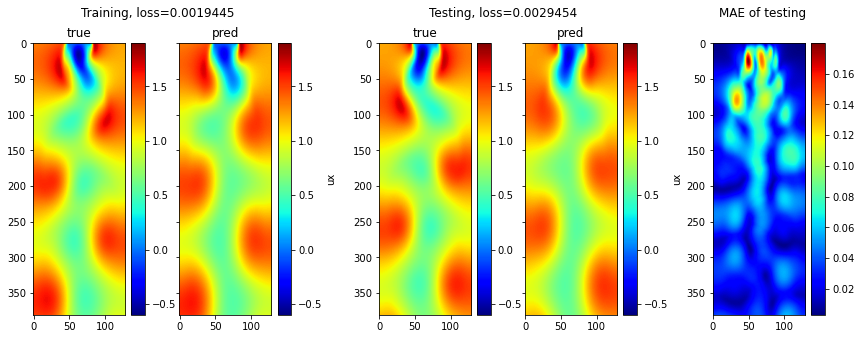

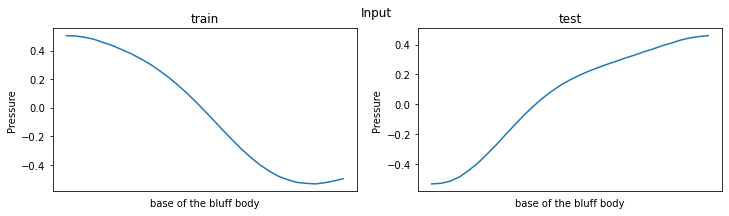

In [15]:
t = 50
fig = plt.figure(figsize=(12,5))
subfigs = fig.subfigures(1, 3, wspace=0.07, width_ratios=[2,2,1])

axl = subfigs[0].subplots(1,2,sharey=True)
subfigs[0].suptitle(f'Training, loss={loss_ux_train:.7f}')
im1 = axl[0].imshow(ux_train[t,:,:]+ux_train_m,'jet',vmax=1.9,vmin=-0.6)
axl[0].set_title('true')
im2 = axl[1].imshow(ux_train_pred[t,...].reshape((nx,ny))+ux_train_m,'jet',vmax=1.9,vmin=-0.6)
axl[1].set_title('pred')
plt.colorbar(im1,ax=axl[0])
plt.colorbar(im2,ax=axl[1],label='ux')

axr = subfigs[1].subplots(1,2,sharey=True)
subfigs[1].suptitle(f'Testing, loss={loss_ux_test:.7f}')
im1 = axr[0].imshow(ux_test[t,:,:]+ux_test_m,'jet',vmax=1.9,vmin=-0.6)
axr[0].set_title('true')
im2 = axr[1].imshow(ux_test_pred[t,...].reshape((nx,ny))+ux_test_m,'jet',vmax=1.9,vmin=-0.6)
axr[1].set_title('pred')
plt.colorbar(im1,ax=axr[0])
plt.colorbar(im2,ax=axr[1],label='ux')

ax = subfigs[2].add_subplot()
im = ax.imshow(loss_ux_plot_test,'jet')
subfigs[2].suptitle("MAE of testing")
plt.colorbar(im,ax=ax)

fig2,ax = plt.subplots(1,2,figsize = (12,3))
ax[0].plot(pb_train[t,:])
ax[0].set_title('train')
ax[0].set_ylabel('Pressure')
ax[0].set_xlabel('base of the bluff body')
ax[0].set_xticks([])
ax[1].plot(pb_test[t,:])
ax[1].set_title('test')
ax[1].set_ylabel('Pressure')
ax[1].set_xlabel('base of the bluff body')
ax[1].set_xticks([])
fig2.suptitle("Input")

plt.show()

## uy

In [16]:
uy_state = state_utils.restore_trainingstate(results_dir,"uy_state")

In [17]:
uy_train_pred = mdl.apply(uy_state.params,pb_train.reshape((ntrain,-1)))
uy_test_pred = mdl.apply(uy_state.params,pb_test.reshape((ntest,-1)))
loss_uy_train = loss(mdl,uy_state.params,pb_train.reshape((ntrain,-1)),uy_train.reshape((ntrain,-1)))
loss_uy_test = loss(mdl,uy_state.params,pb_test.reshape((ntest,-1)),uy_test.reshape(ntest,-1))
print(f"loss for training and testing set: {loss_uy_train:.7f}, {loss_uy_test:.7f}.")

loss for training and testing set: 0.0055675, 0.0093552.


In [18]:
loss_uy_plot_test = mae_plane(uy_test_pred.reshape((ntest,nx,ny)),uy_test)

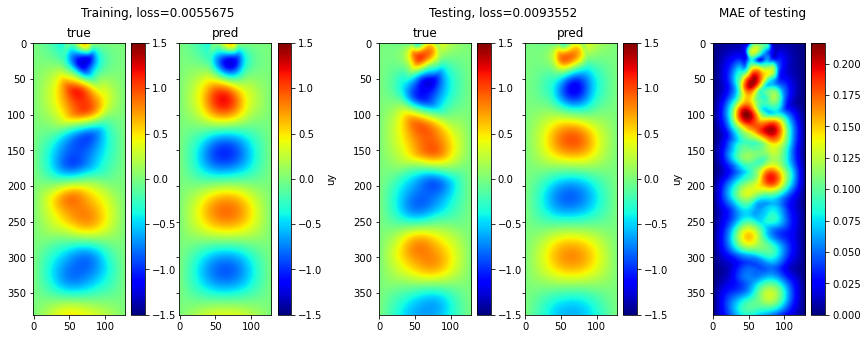

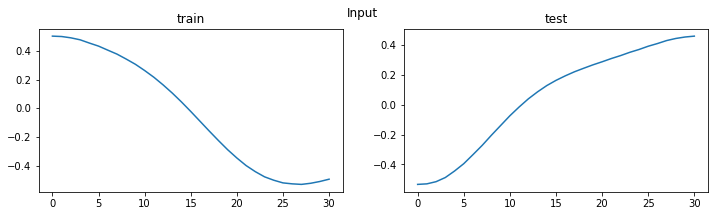

In [19]:
fig = plt.figure(figsize=(12,5))
subfigs = fig.subfigures(1, 3, wspace=0.07, width_ratios=[2,2,1])

axl = subfigs[0].subplots(1,2,sharey=True)
subfigs[0].suptitle(f'Training, loss={loss_uy_train:.7f}')
im1 = axl[0].imshow(uy_train[t,:,:]+uy_train_m,'jet',vmax=1.5,vmin=-1.5)
axl[0].set_title('true')
im2 = axl[1].imshow(uy_train_pred[t,...].reshape((nx,ny))+uy_train_m,'jet',vmax=1.5,vmin=-1.5)
axl[1].set_title('pred')
plt.colorbar(im1,ax=axl[0])
plt.colorbar(im2,ax=axl[1],label='uy')

axr = subfigs[1].subplots(1,2,sharey=True)
subfigs[1].suptitle(f'Testing, loss={loss_uy_test:.7f}')
im1 = axr[0].imshow(uy_test[t,:,:]+uy_test_m,'jet',vmax=1.5,vmin=-1.5)
axr[0].set_title('true')
im2 = axr[1].imshow(uy_test_pred[t,...].reshape((nx,ny))+uy_test_m,'jet',vmax=1.5,vmin=-1.5)
axr[1].set_title('pred')
plt.colorbar(im1,ax=axr[0])
plt.colorbar(im2,ax=axr[1],label='uy')

ax = subfigs[2].add_subplot()
im = ax.imshow(loss_uy_plot_test,'jet')
subfigs[2].suptitle("MAE of testing")
plt.colorbar(im,ax=ax)


fig2,ax = plt.subplots(1,2,figsize = (12,3))
ax[0].plot(pb_train[t,:])
ax[0].set_title('train')
ax[1].plot(pb_test[t,:])
ax[1].set_title('test')
fig2.suptitle("Input")

plt.show()

## Divergence

In [20]:
def get_div_field(u,v,dx=1,dy=1):
    dudx = jnp.gradient(u,dx,axis=1)
    dvdy = jnp.gradient(v,dy,axis=2)
    div = dudx + dvdy
    return div


In [21]:
div_train = get_div_field(ux_train,uy_train,12/512,4/128)
div_train_m = np.mean(div_train,axis=0)
div_train_std = np.std(div_train,axis=0)

div_test = get_div_field(ux_test,uy_test,12/512,4/128)
div_test_m = np.mean(div_test,axis=0)
div_test_std = np.std(div_test,axis=0)

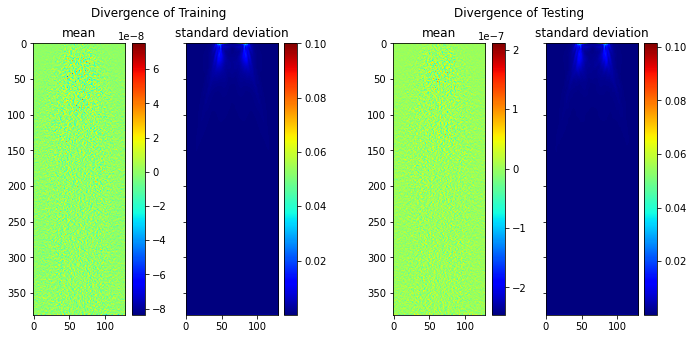

In [22]:
fig = plt.figure(figsize=(10,5))
subfigs = fig.subfigures(1, 2, wspace=0.07)

axl = subfigs[0].subplots(1,2,sharey=True)
subfigs[0].suptitle('Divergence of Training')
im1 = axl[0].imshow(div_train_m,'jet')
axl[0].set_title('mean')
im2 = axl[1].imshow(div_train_std,'jet')
axl[1].set_title('standard deviation')
plt.colorbar(im1,ax=axl[0])
plt.colorbar(im2,ax=axl[1])

axr = subfigs[1].subplots(1,2,sharey=True)
subfigs[1].suptitle('Divergence of Testing')
im1 = axr[0].imshow(div_test_m,'jet')
axr[0].set_title('mean')
im2 = axr[1].imshow(div_test_std,'jet')
axr[1].set_title('standard deviation')
plt.colorbar(im1,ax=axr[0])
plt.colorbar(im2,ax=axr[1])
plt.show()

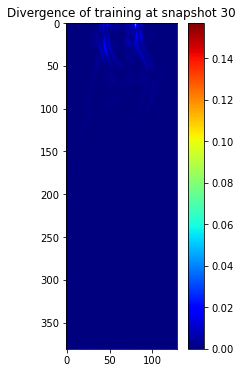

In [23]:
t = 30
plt.figure(figsize=(4,6))
plt.imshow(np.abs(div_train[t,...]),'jet')
plt.colorbar()
plt.title(f'Divergence of training at snapshot {t}')
plt.show()

# Combined

In [9]:
state = state_utils.restore_trainingstate(results_dir,'state')
jax.tree_util.tree_map(lambda x: print(x.shape),state.params)

(31,)
(31, 31)
(98298,)
(31, 98298)


{'mlp/~/linear_0': {'b': None, 'w': None},
 'mlp/~/linear_1': {'b': None, 'w': None}}

In [12]:
ux_train = np.reshape(ux_train,(ntrain,-1))
ux_test = np.reshape(ux_test,(ntest,-1))
uy_train = np.reshape(uy_train,(ntrain,-1))
uy_test = np.reshape(uy_test,(ntest,-1))
u_train = np.hstack((ux_train,uy_train))
u_test = np.hstack((ux_test,uy_test))
pb_train = pb_train.reshape((ntrain,-1))
pb_test = pb_test.reshape((ntest,-1))

In [16]:
u_train_pred = mdl.apply(state.params,None,pb_train)
u_test_pred = mdl.apply(state.params,None,pb_test)
train_loss = mse(u_train_pred,u_train)
test_loss = mse(u_test_pred,u_test)
print(f"loss for training and testing set: {train_loss:.7f}, {test_loss:.7f}.")

loss for training and testing set: 0.0000017, 0.0004392.


In [21]:
ux_train_pred = u_train_pred[:,:nx*ny].reshape((ntrain,nx,ny))
ux_train = ux_train.reshape((ntrain,nx,ny))
ux_test_pred = u_test_pred[:,:nx*ny].reshape((ntest,nx,ny))
ux_test = ux_test.reshape((ntest,nx,ny))
uy_train_pred = u_train_pred[:,nx*ny:].reshape((ntrain,nx,ny))
uy_train = uy_train.reshape((ntrain,nx,ny))
uy_test_pred = u_test_pred[:,nx*ny:].reshape((ntest,nx,ny))
uy_test = uy_test.reshape((ntest,nx,ny))

In [22]:
test_mae_ux = mae_plane(ux_test_pred,ux_test)
train_mae_ux = mae_plane(ux_train_pred,ux_train)
test_mae_uy = mae_plane(uy_test_pred,uy_test)
train_mae_uy = mae_plane(uy_train_pred,uy_train)

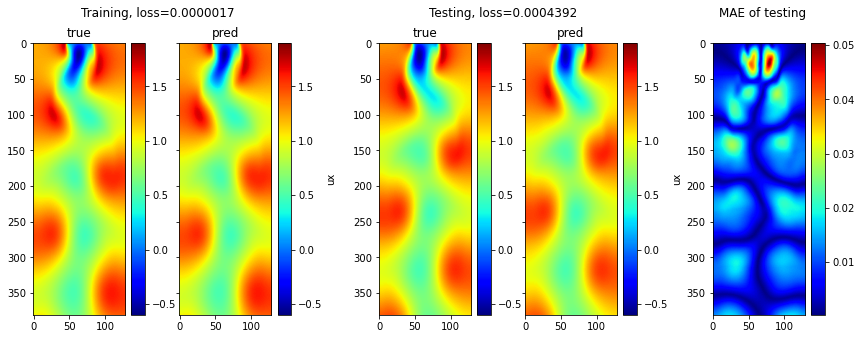

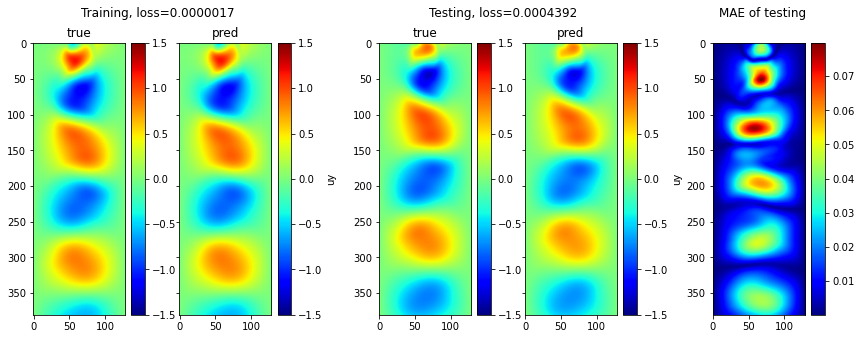

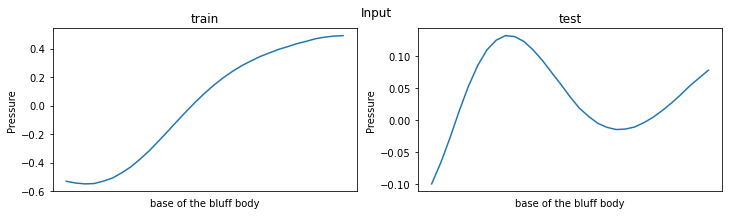

In [26]:
t = 50

# ux
fig = plt.figure(figsize=(12,5))
subfigs = fig.subfigures(1, 3, wspace=0.07, width_ratios=[2,2,1])

axl = subfigs[0].subplots(1,2,sharey=True)
subfigs[0].suptitle(f'Training, loss={train_loss:.7f}')
im1 = axl[0].imshow(ux_train[t,:,:]+ux_train_m,'jet',vmax=1.9,vmin=-0.6)
axl[0].set_title('true')
im2 = axl[1].imshow(ux_train_pred[t,...]+ux_train_m,'jet',vmax=1.9,vmin=-0.6)
axl[1].set_title('pred')
plt.colorbar(im1,ax=axl[0])
plt.colorbar(im2,ax=axl[1],label='ux')

axr = subfigs[1].subplots(1,2,sharey=True)
subfigs[1].suptitle(f'Testing, loss={test_loss:.7f}')
im1 = axr[0].imshow(ux_test[t,:,:]+ux_test_m,'jet',vmax=1.9,vmin=-0.6)
axr[0].set_title('true')
im2 = axr[1].imshow(ux_test_pred[t,...]+ux_test_m,'jet',vmax=1.9,vmin=-0.6)
axr[1].set_title('pred')
plt.colorbar(im1,ax=axr[0])
plt.colorbar(im2,ax=axr[1],label='ux')

ax = subfigs[2].add_subplot()
im = ax.imshow(test_mae_ux,'jet')
subfigs[2].suptitle("MAE of testing")
plt.colorbar(im,ax=ax)


# uy
fig = plt.figure(figsize=(12,5))
subfigs = fig.subfigures(1, 3, wspace=0.07, width_ratios=[2,2,1])

axl = subfigs[0].subplots(1,2,sharey=True)
subfigs[0].suptitle(f'Training, loss={train_loss:.7f}')
im1 = axl[0].imshow(uy_train[t,:,:]+uy_train_m,'jet',vmax=1.5,vmin=-1.5)
axl[0].set_title('true')
im2 = axl[1].imshow(uy_train_pred[t,...]+uy_train_m,'jet',vmax=1.5,vmin=-1.5)
axl[1].set_title('pred')
plt.colorbar(im1,ax=axl[0])
plt.colorbar(im2,ax=axl[1],label='uy')

axr = subfigs[1].subplots(1,2,sharey=True)
subfigs[1].suptitle(f'Testing, loss={test_loss:.7f}')
im1 = axr[0].imshow(uy_test[t,:,:]+uy_test_m,'jet',vmax=1.5,vmin=-1.5)
axr[0].set_title('true')
im2 = axr[1].imshow(uy_test_pred[t,...]+uy_test_m,'jet',vmax=1.5,vmin=-1.5)
axr[1].set_title('pred')
plt.colorbar(im1,ax=axr[0])
plt.colorbar(im2,ax=axr[1],label='uy')

ax = subfigs[2].add_subplot()
im = ax.imshow(test_mae_uy,'jet')
subfigs[2].suptitle("MAE of testing")
plt.colorbar(im,ax=ax)

# inputs
fig2,ax = plt.subplots(1,2,figsize = (12,3))
ax[0].plot(pb_train[t,:])
ax[0].set_title('train')
ax[0].set_ylabel('Pressure')
ax[0].set_xlabel('base of the bluff body')
ax[0].set_xticks([])
ax[1].plot(pb_test[t,:])
ax[1].set_title('test')
ax[1].set_ylabel('Pressure')
ax[1].set_xlabel('base of the bluff body')
ax[1].set_xticks([])
fig2.suptitle("Input")

plt.show()